In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, precision_score, precision_recall_curve, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

data = pd.read_csv('mushrooms.csv')

# EDA. Anàlisi de les dades

Per començar a treballar amb les dades, hem d'analitzar quin tipus d'informació tenim. Utilitzarem el mètode info() per obtenir una visió general i verificar si existeixen o no valors nuls.

In [4]:
print("Informació general del dataset:")
data.info()

print("\nValors únics per cada columna:")
for col in data.columns:
    print(f"{col}: {data[col].unique()[:5]}... ({len(data[col].unique())} únics)")

Informació general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   obje

En primera instància observem que tenim 8124 entrades i 23 columnes (totes categòriques), on les quals no trobem cap indici que tinguin valors nuls. Tot i això, més endavant, afegirem alguns valors nuls aleatòriament per veure com varia el nostre model. També podem veure els diferents valors únics de cada columna per observar quantes categories hi ha per cada columna i tenir una idea de la diversitat de dades que hi ha. La nostra columna objectiu es "class" la qual conté dues classes: e (comestible) i p (verinós):

Porcentatge de les classes:
class
e    51.797144
p    48.202856
Name: proportion, dtype: float64


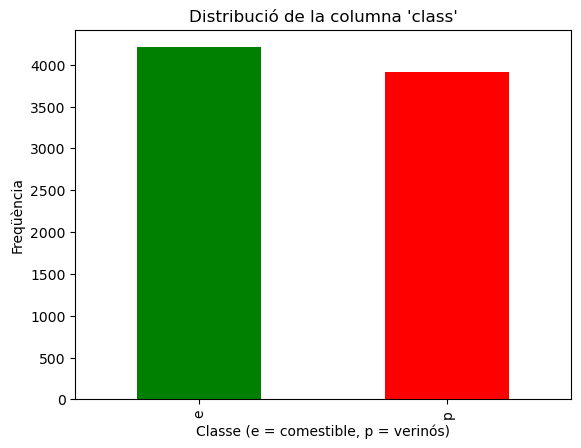

In [5]:
print("Porcentatge de les classes:")
print(data['class'].value_counts(normalize=True)*100)

data['class'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Distribució de la columna 'class'")
plt.xlabel("Classe (e = comestible, p = verinós)")
plt.ylabel("Freqüència")
plt.show()

El dataset està bastant balancejat, ja que les dues classes tenen una proporció molt semblant, així que no caldria cap mètode de balancejament.

# Preprocessing

Com s'ha observat anteriorment, en cap columna tenim valors nuls, però totes les columnes són categòriques, per tant, haurem de fer un tractament a aquestes columnes per poder-les codificar i així mirar les correlacions existents entre la columna objectiu 'class' i la resta:

In [6]:
codificacio = {}
data_codificada = data.copy()

for col in data.columns:
    le = LabelEncoder()
    data_codificada[col] = le.fit_transform(data[col])
    codificacio[col] = le

X = data_codificada.drop('class', axis=1)
y = data_codificada['class']

print("Dataset codificat:")
print(data_codificada)

Dataset codificat:
      class  cap-shape  cap-surface  cap-color  bruises  odor  \
0         1          5            2          4        1     6   
1         0          5            2          9        1     0   
2         0          0            2          8        1     3   
3         1          5            3          8        1     6   
4         0          5            2          3        0     5   
...     ...        ...          ...        ...      ...   ...   
8119      0          3            2          4        0     5   
8120      0          5            2          4        0     5   
8121      0          2            2          4        0     5   
8122      1          3            3          4        0     8   
8123      0          5            2          4        0     5   

      gill-attachment  gill-spacing  gill-size  gill-color  ...  \
0                   1             0          1           4  ...   
1                   1             0          0           4  ...   

S'ha utilitzats la codificació "ordinal encoding", que per cada valor únic que es troba a la columna, se li assigna un número enter. Ara anem a veure les diferents correlacions que trobem:

In [7]:
mutual_info = mutual_info_classif(X, y, discrete_features=True)
correlacions = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)
print("Correlacions entre 'class' i la resta de columnes: ")
print(correlacions)

Correlacions entre 'class' i la resta de columnes: 
odor                        0.628043
spore-print-color           0.333199
gill-color                  0.289027
ring-type                   0.220436
stalk-surface-above-ring    0.197357
stalk-surface-below-ring    0.188463
stalk-color-above-ring      0.175952
stalk-color-below-ring      0.167337
gill-size                   0.159531
population                  0.139987
bruises                     0.133347
habitat                     0.108709
stalk-root                  0.093448
gill-spacing                0.069927
cap-shape                   0.033823
ring-number                 0.026653
cap-color                   0.024987
cap-surface                 0.019817
veil-color                  0.016509
gill-attachment             0.009818
stalk-shape                 0.005210
veil-type                   0.000000
dtype: float64


Per veure-ho de manera més clara:

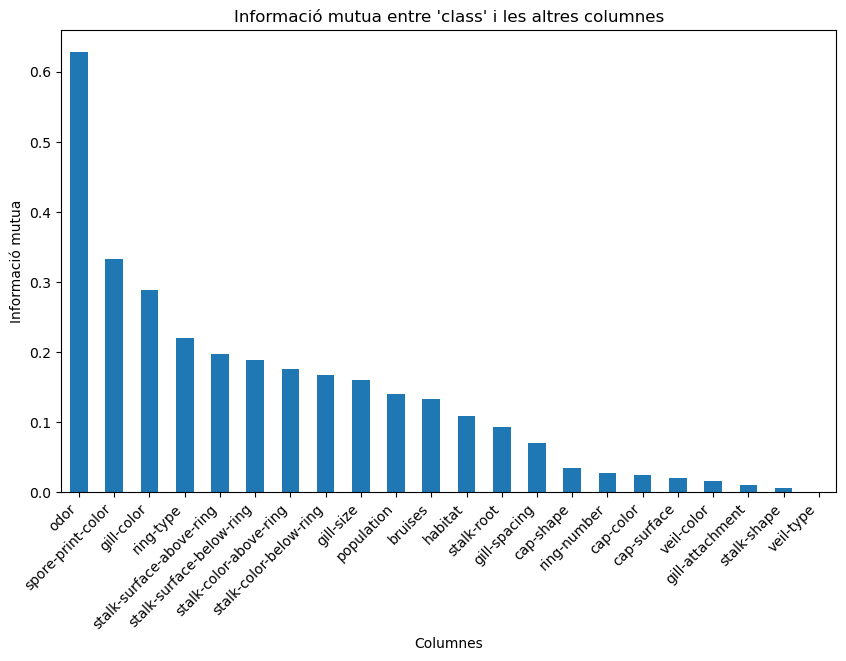

In [8]:
plt.figure(figsize=(10,6))
correlacions.plot(kind='bar')
plt.title("Informació mutua entre 'class' i les altres columnes")
plt.xlabel("Columnes")
plt.ylabel("Informació mutua")
plt.xticks(rotation=45, ha='right')
plt.show()

La columna odor és la columna que més informació ens dona per determinar la classe de bolet, ja que té una forta dependència i ens diu que la olor por determinar bastant si el bolet es pot menjar o no. El color de les espores, de les brànquies o la superfície del peu del bolet també ens dona bastanta informació (no tant com la olor). 

De moment, farem servir el dataset sense modificar-lo gaire per veure quins resultats obtenim. Tot i això, ja veiem que hi ha atributs que, a priori, aporten molt poca informació de cara a determinar si un bolet és verinós o no, per tant, més endavant podriem probar a eliminar-los i veure si hi ha canvis en les mètriques.

# Metric Selection

Ara que ja hem fet un tractament de les dades i, abans de començar a entrenar el nostre classificador, hem de decidir quina serà la nostra mètrica objectiu a maximitzar. En aquest cas, estem parlant de determinar si un bolet és verinós o no, aleshores, obtenir un bon recall serà una prioritat ja que ens interessa assegurar-nos de que reconeixem tots els bolets que poden ser perillossos encara que això pugui suposar un augment de falsos positius. Tot i això, sempre serà millor classificar un bolet com a verinós i que no ho sigui que viceversa.

En segon lloc, un cop haguem aconseguit un bon recall ens interessarà també obtenir una bona precisió, ja que així ens assegurarem de que no només endevinem quins són verinossos, sinó que minimitzem el nombre de falsos positius, donant resultats més fiables.

Finalment, una mètrica com el f1-score pot ser interessant de cara a obtenir un punt mig entre prioritzar precision o prioritzar recall (ja que té en compte les dues) i, l'accuracy, seria l'última mètrica a maximitzar.

# Model Selection

NOTA: En quant a les mètriques obtingudes sempre hi pot haver una petita variació amb els resultats mencionats ja que hi ha successos aleatoris, com l'split de la funció train_test_split o els splits del cross-validation utilitzat pel GridSearch

Ara mateix ja tenim el dataset tractat i hem decidit quina prioritat li donem a cada mètrica de cada a avaluar el nostre model. Per tant, és moment d'entrenar diferents classificadors utilitzant diferents tècniques; com poden ser gridsearch o cross-validation per tal de veure quin classificador considerem òptim per a aquesta tasca de classificació.

Abans de començar, com que no se'ns proporcionen dades de test, farem un split de les dades per tal de tenir un conjunt de train i un de validacióo, on poder probar, encara que sigui de forma inicial, els models que entrenem.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #20% de dades per les proves

De cara a avaluar els nostres classificadors definirem alguna funció per a que ens sigui més fàcil i ràpid veure quins resultats donen:

In [10]:
def performanceIndividual(Y, predictions, model_name):
        """
        Aquesta funcio, donades les prediccions del model i el ground truth, calcula i mostra les mètriques: accuracy,
        precisió, recall i f1-score, a més de mostrar la matriu de confusió i les corves ROC i PR.
        """
        acc = accuracy_score(Y, predictions)
        prec = precision_score(Y, predictions)
        rec = recall_score(Y, predictions)
        f1 = f1_score(Y, predictions)
        conf_mat = confusion_matrix(Y, predictions)

        print('-' * 25)
        print('>>> Rendiment del model %s:' %(model_name))
        print(f'- Accuracy: {round(acc, 3)}')
        print(f'- Precision: {round(prec, 3)}')
        print(f'- Recall (Sensitivity, TPR): {round(rec, 3)}')
        print(f'- F1-score: {round(f1, 3)}')
        print('-' * 25)
      
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)  
        disp.plot()  
        plt.title("Conf Matrix")
        plt.show()
        prec, rec, _= precision_recall_curve(Y, predictions)
        fpr, tpr, _= roc_curve(Y, predictions)

        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        plt.plot(rec, prec)
        plt.title("PR Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")

        plt.subplot(1,2,2)
        plt.plot(fpr, tpr)
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()

Al ser un dataset ple de dades categòriques i, per tant, on cada atribut està dividit en unes classes ben diferenciades, una bona primera opció serà un decision tree.

-------------------------
>>> Rendiment del model Decision Tree:
- Accuracy: 0.922
- Precision: 0.967
- Recall (Sensitivity, TPR): 0.874
- F1-score: 0.918
-------------------------


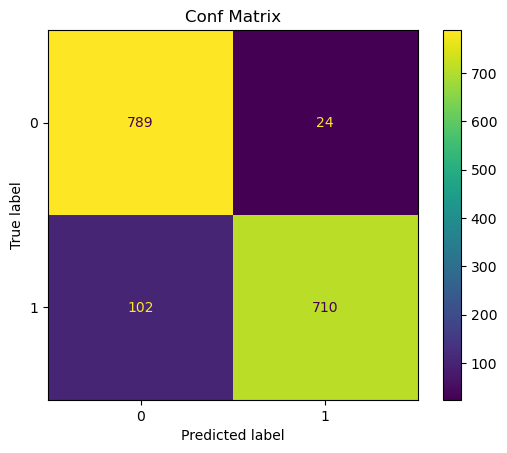

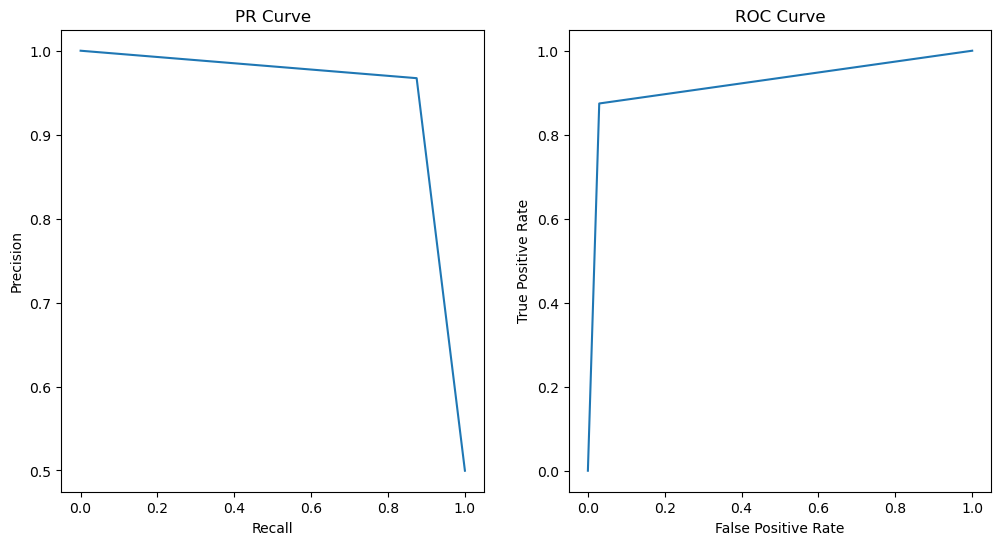

In [11]:
decTree = DecisionTreeClassifier(max_depth = 2)
decTree.fit(X=X_train, y=y_train)
decTreePredictions = decTree.predict(X=X_test)
performanceIndividual(y_test, decTreePredictions, "Decision Tree")
            

Com podem observar, un decision tree simple amb una max_depth = 2 ja dona uns resultats molt bons a les mètriques triades. Com podem observar, la mètrica amb un rendiment pitjor és el recall, amb un 85%. Tot i que no estiguin gens malament els resultats, encara tenim possibilitat de millora fent servir, per exemple, un gridsearch per a trobar els millors valors de cada paràmetre i, òbviament, podem utilitzar un Random Forests que, al cap i a la fi, no deixa de ser un conjunt de Decision Trees. Com ja hem dit prèviament, maximitzar el recall és una prioritat i, per tant, encara podem mirar de filar una mica més prim.

-------------------------
>>> Rendiment del model Support Vector Machine:
- Accuracy: 0.987
- Precision: 0.999
- Recall (Sensitivity, TPR): 0.975
- F1-score: 0.987
-------------------------


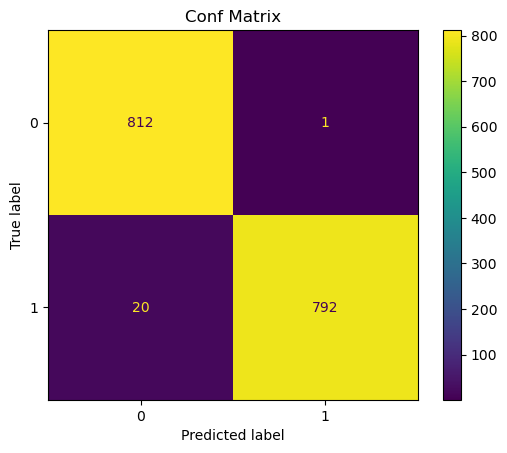

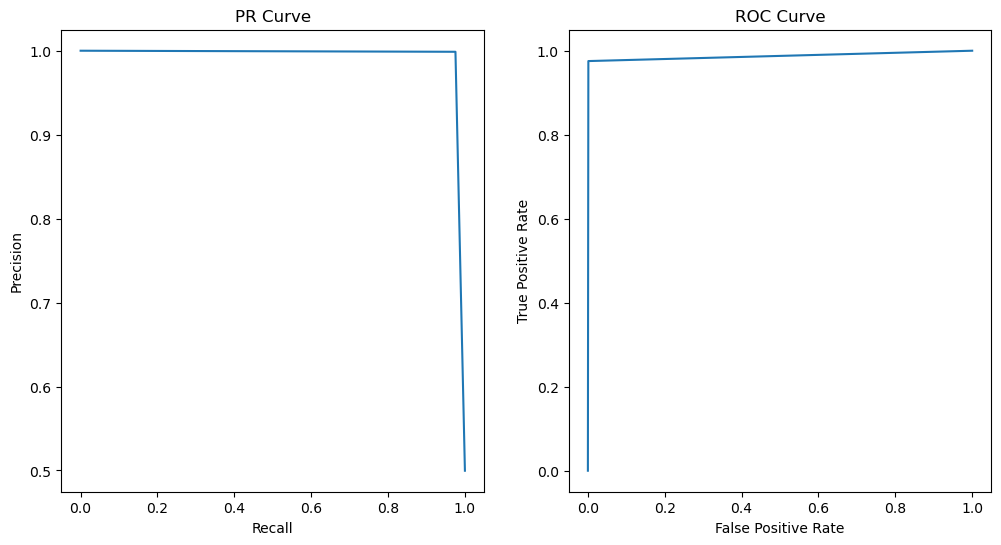

In [12]:
svm = SVC()
svm.fit(X=X_train, y=y_train)
svmPredictions = svm.predict(X=X_test)
performanceIndividual(y_test, svmPredictions, "Support Vector Machine")
            

Com podem observar, en el cas del Support Vector Machine, obtenim uns resultats pràcticament perfectes, sent el recall el punt més feble del classificador, amb un valor del 98,4%, que segueix sent molt molt bo. Cal a dir, també, que ha trigat entre 3 i 4 cops més que el Decision Tree, per tant, és lògic que obtinguem resultats millors. Encara així, el SVM ens ha mostrat que és una molt bona opció per a aquesta tasca de classificació.

Tenint en compte els bons resultats del Support Vector Machine, podem pensar que una Regressió Logística també pot ser un bon classificador, comprovem-ho:

-------------------------
>>> Rendiment del model Logistic Regression:
- Accuracy: 0.946
- Precision: 0.951
- Recall (Sensitivity, TPR): 0.94
- F1-score: 0.945
-------------------------


c:\Users\roger\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


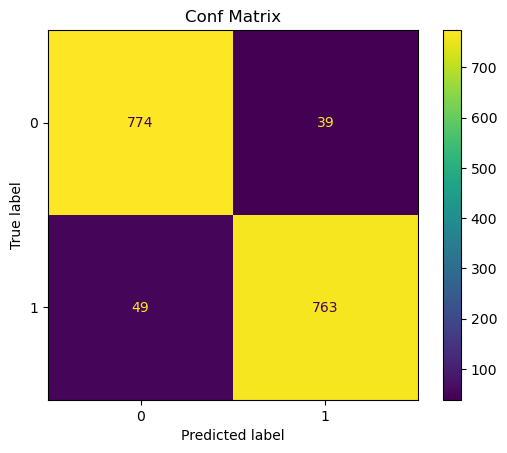

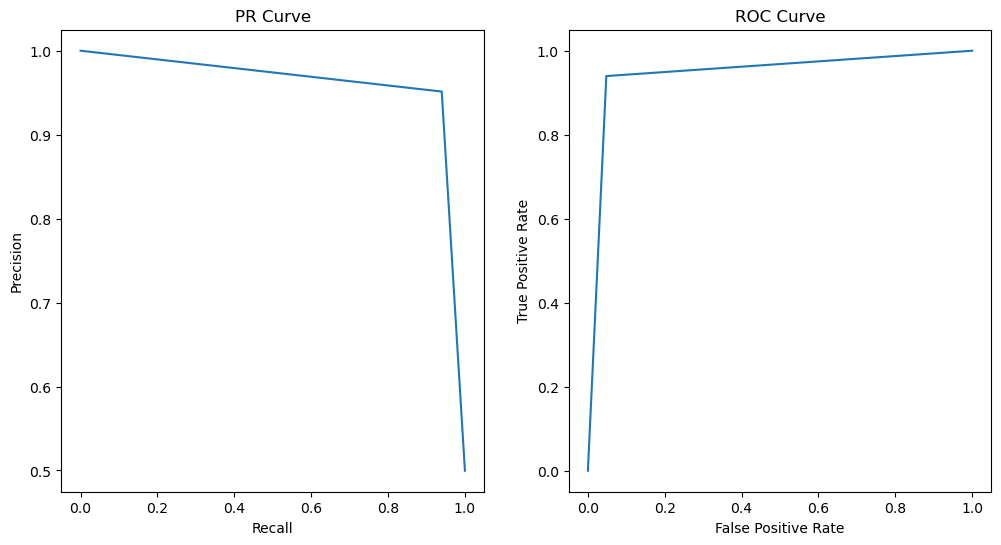

In [13]:
logReg = LogisticRegression()
logReg.fit(X=X_train, y=y_train)
logRegPredictions = logReg.predict(X=X_test)
performanceIndividual(y_test, logRegPredictions, "Logistic Regression")
            

Com podem observar, tot i que la Regressió Logóistica obtingui uns resultats una mica pitjors que el SVM, no deixen de ser excel·lents. Més encara si tenim en compte que no hem "jugat" en absolut amb cap hiperparàmetre i que, per tant, tenim encara un ampli marge de millora en quant a opcions. Seguint la moda dels altres classificadors, el recall ha estat la mètrica més fluixa, amb un 94,8% en aquest cas.

### Optimització dels Classificadors

Ara que ja tenim 3 classificadors viables (4, si comptem la opció d'utilitzar Random Forests), convindria dur a terme un grid-search per a trobar el millor conjunt d'hiperparàmetres per a cada un. Això ens permetrà tenir els classificadors optimitzats per a aquesta tasca i, així, si més tard volem probar a afegir nulls, intentar predir una altra característica o qualsevol altra proba, ho farem amb els classificadors ja optimitzats.

Igual que abans, començarem amb el Decision Tree:

Els millors paràmetres són: 
{'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}
-------------------------
>>> Rendiment del model Decision Tree:
- Accuracy: 0.989
- Precision: 1.0
- Recall (Sensitivity, TPR): 0.978
- F1-score: 0.989
-------------------------


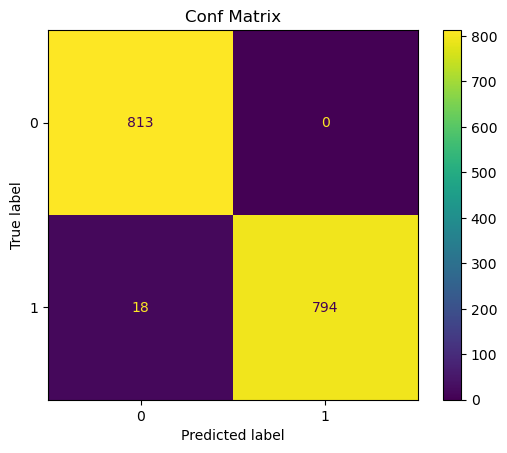

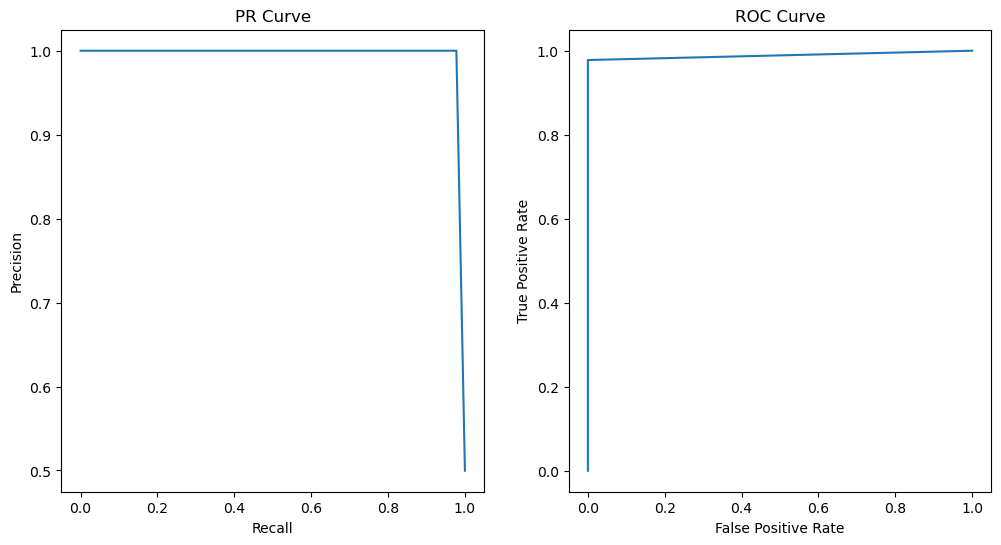

In [14]:
decTreeGS = DecisionTreeClassifier()
params = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ('best', 'random'), 'max_depth':[1,2,3,4,5]}
decTreeGS = GridSearchCV(decTreeGS, params)
decTreeGS.fit(X_train, y_train)
best_params = decTreeGS.best_params_
print("Els millors paràmetres són: ")
print(best_params)
decTreeGSPreds = decTreeGS.predict(X_test)
performanceIndividual(y_test, decTreeGSPreds, "Decision Tree")

Com podem observar, aquest gridSearch ha millorat molt el rendiment del Decision Tree ja que obtenim sempre mètriques que no baixen del 98%. Aquesta és una millora important ja que, si fem memòria, abans el Decision Tree donava bons accuracy i precision però un recall del 82-85%. Per tant, aquesta millora, sobretot en el recall és notòria.

Ara és torn del SVM:

Els millors paràmetres són: 
{'C': 10, 'kernel': 'rbf'}
-------------------------
>>> Rendiment del model SVM:
- Accuracy: 1.0
- Precision: 1.0
- Recall (Sensitivity, TPR): 1.0
- F1-score: 1.0
-------------------------


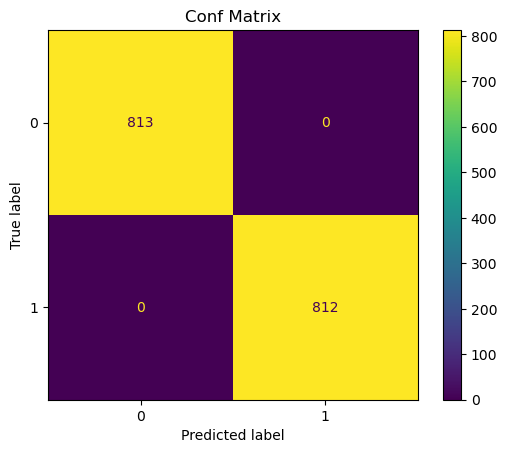

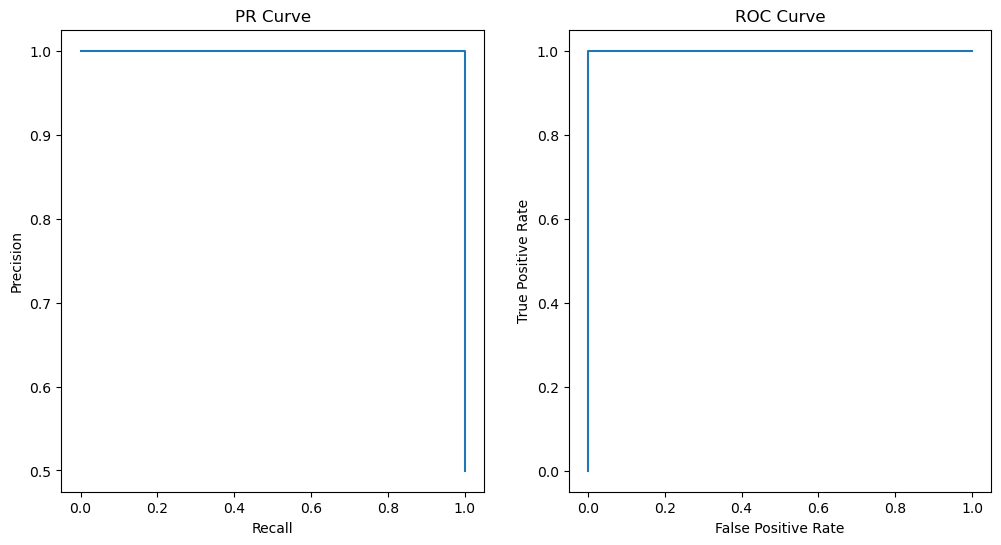

In [15]:
svmGS = SVC()
params = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svmGS = GridSearchCV(svmGS, params)
svmGS.fit(X_train, y_train)
best_params = svmGS.best_params_
print("Els millors paràmetres són: ")
print(best_params)
svmGSPreds = svmGS.predict(X_test)
performanceIndividual(y_test, svmGSPreds, "SVM")

Tot i que els resultats del SVM ja eren prou bons, l'aplicació del GridSearch ha fet que aquests resultats siguin perfectes, obtenint un rendiment del 100% en totes les mètriques. El SVM, per tant, és un classificador idoni per a aquesta tasca de classificació i, ara mateix, és el model a utilitzar dels que hem vist.

Finalment, ens quedarà veure la Logistic Regression:

c:\Users\roger\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\roger\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Els millors paràmetres són: 
{'C': 1000, 'penalty': 'l2'}
-------------------------
>>> Rendiment del model Logistic Regression:
- Accuracy: 0.955
- Precision: 0.959
- Recall (Sensitivity, TPR): 0.951
- F1-score: 0.955
-------------------------


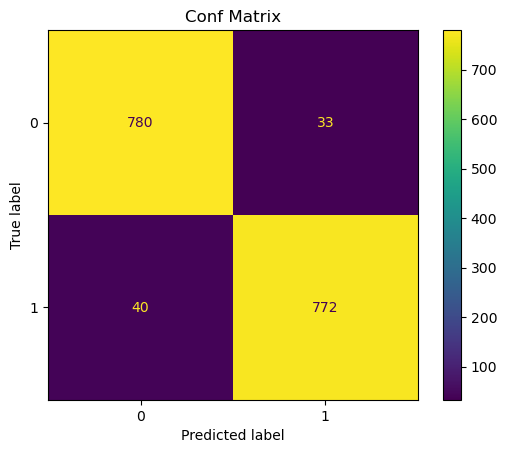

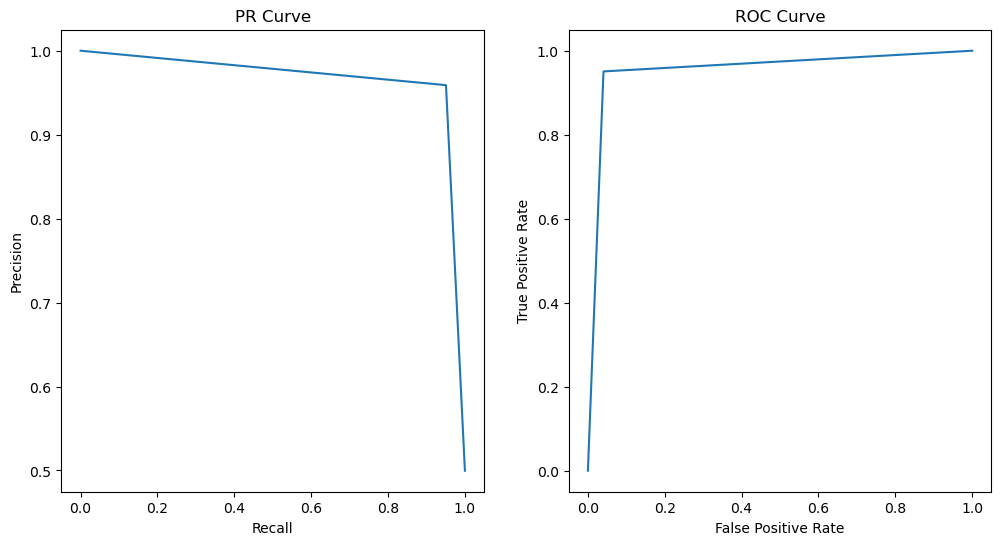

In [16]:
logRegGS = LogisticRegression()
params = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
logRegGS = GridSearchCV(logRegGS, params)
logRegGS.fit(X_train, y_train)
best_params = logRegGS.best_params_
print("Els millors paràmetres són: ")
print(best_params)
logRegGSPreds = logRegGS.predict(X_test)
performanceIndividual(y_test, logRegGSPreds, "Logistic Regression")

Com veiem a les mètriques, no hi ha gaire diferència entre els resultats obtinguts prèviament amb la Regressió Logística i els obtinguts amb la millor combinació de paràmetres del GridSearch. Això no és dolent, ja que aquest classificador ja obtenia bons resultats però, sí que provoca que es quedi enrere respecte al SVM.

Com a proba extra, ja que no hem fet servir cap ensemble, farem un gridSearch de Random Forest a veure quins resultats dona:

Els millors paràmetres són: 
{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 150}
-------------------------
>>> Rendiment del model Random Forest:
- Accuracy: 0.99
- Precision: 1.0
- Recall (Sensitivity, TPR): 0.979
- F1-score: 0.989
-------------------------


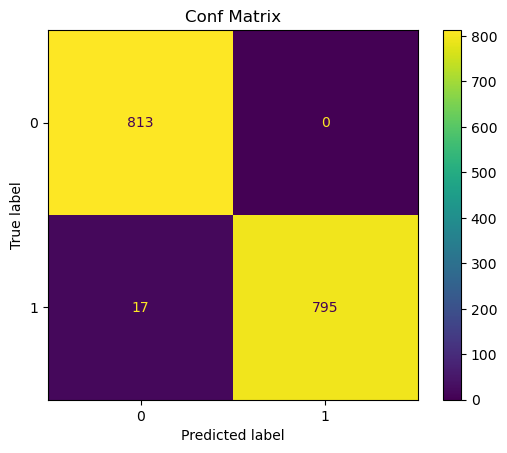

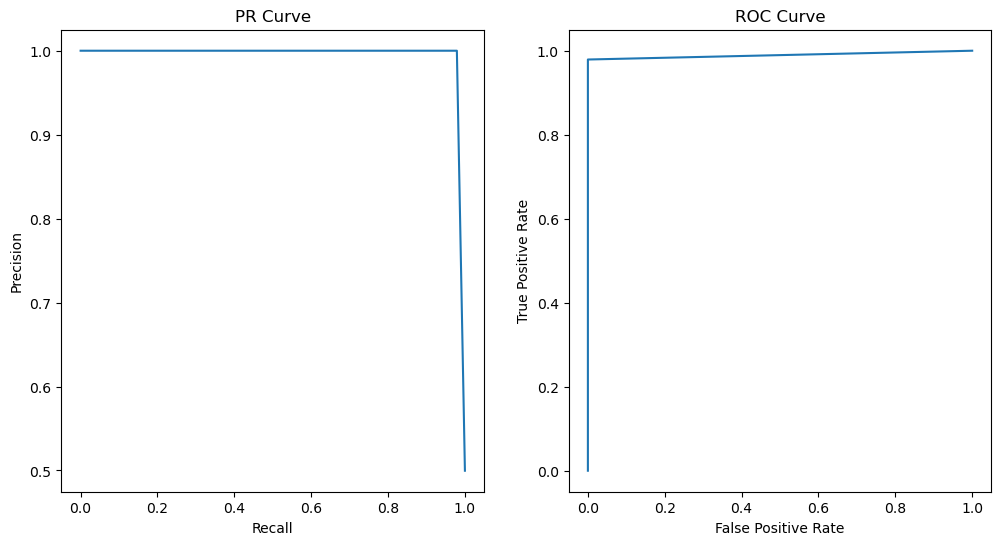

In [17]:
RandForest = RandomForestClassifier()
params = {'n_estimators':[1, 50, 100, 150, 200], 'criterion':['gini', 'entropy', 'log_loss'], 'max_depth':[1,2,3,4,5]}
RandForest = GridSearchCV(RandForest, params)
RandForest.fit(X_train, y_train)
best_params = RandForest.best_params_
print("Els millors paràmetres són: ")
print(best_params)
RandForestPreds = RandForest.predict(X_test)
performanceIndividual(y_test, RandForestPreds, "Random Forest")


# Analisi final

Com hem pogut observar en els diferents models, el millor que hem trobat és el de Support Vector Machine amb els següents paràmetres: 'C': 10, 'kernel': 'rbf'. Les seves mètriques tenen un valor perfecte de 1.0: l'accuracy indica que totes les prediccions del model han estat correctes, la precisió indica que no hi ha falsos positius, el recall que no hi ha falsos negatius i el f1-score indica un balanç perfecte entre aquestes mètriques.

In [19]:
svmGS = SVC()
params = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svmGS = GridSearchCV(svmGS, params)
svmGS.fit(X_train, y_train)
best_params = svmGS.best_params_
print("Els millors paràmetres són: ")
print(best_params)
svmGSPreds = svmGS.predict(X_test)

Els millors paràmetres són: 
{'C': 10, 'kernel': 'rbf'}


La corba PR representa la relació entre la precisió i el recall amb els diferents llindars de classificació. Tant la precisió com el recall és de 1.0, per tant, classifica les dades perfectament.
La corba ROC representa la relació entre la tasa dels True Positive i la tasa dels False Positive. Com no tenim False Positive, té un rendiment òptim ja que la tasa de True Positive és d'1.

-------------------------
>>> Rendiment del model SVM:
- Accuracy: 1.0
- Precision: 1.0
- Recall (Sensitivity, TPR): 1.0
- F1-score: 1.0
-------------------------


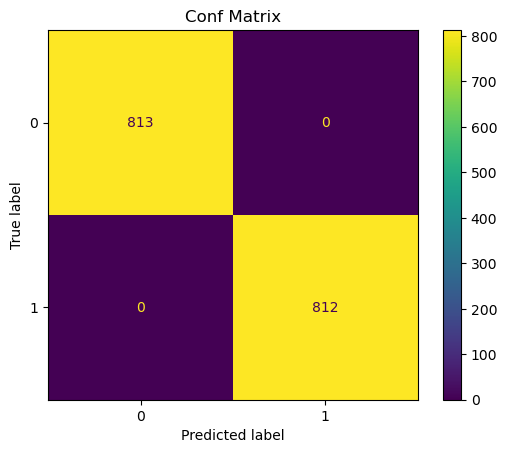

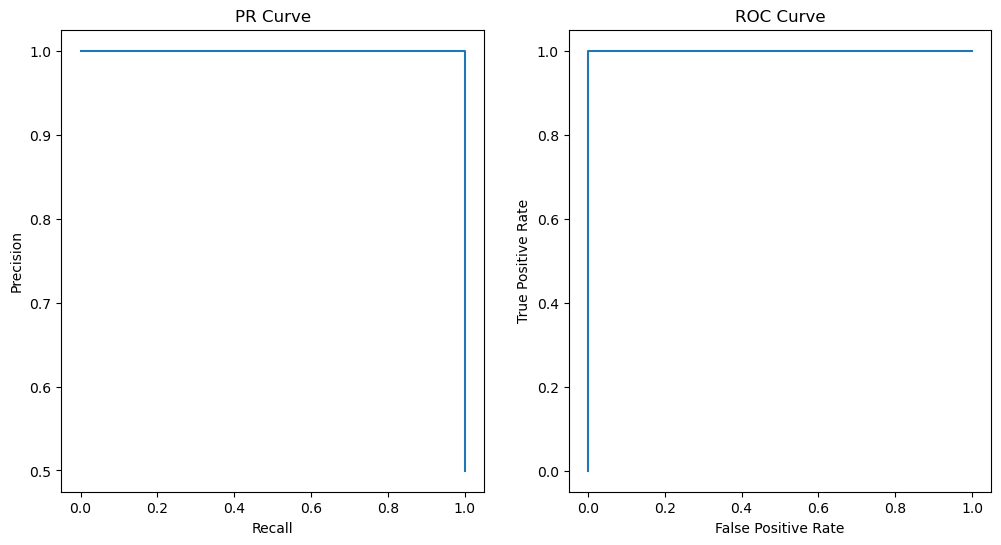

In [20]:
performanceIndividual(y_test, svmGSPreds, "SVM")

Aquest classificador pot ser útil en diferents contexts com en una aplicació mòbil per reconèixer si els bolets són comestibles o no, integrar el classificador en plataformes d'aprenentatge, pot servir per agricultors, per persones que treballen en l'àmbit sanitari, investigacions científiques, per cuiners, etc.

El nostre model té un rendiment perfecte, no obstant, augmentant el nostre dataset amb més dades, es podria acabar d'ajustar el model i tenir una validació creuada amb més particions i per tant més estricta, assegurant que el nostre model generalitzi bé. 